In [1]:
consumer_key = "3CPSX6vE31S6wiyUFpc45wqd6"
consumer_key_secret = "mbuRYtNTaFLYC5IRrW2Dz6mj5fXlkv0SgIk5OCSLqLYHQMXR0O"
access_token = "391364404-IiRlLVX4KO1OiTFbtpMEWjzNoV07AJI7YPd8z1kD"
access_token_secret = "qvmLo4zi3tcQWJIYZQkrB2P0iwcuzHLaLmTBpo98HYmNg"

In [2]:
import tweepy
import matplotlib.pyplot as plt
import pytz

auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [3]:
# fetching trends in New Delhi
trends_raw = api.trends_place(id=20070458)
# filtering top 3 trends
trends_raw[0]['trends'][:3]

[{'name': 'Canada',
  'url': 'http://twitter.com/search?q=Canada',
  'promoted_content': None,
  'query': 'Canada',
  'tweet_volume': 221779},
 {'name': '#100FREEiPhone12',
  'url': 'http://twitter.com/search?q=%23100FREEiPhone12',
  'promoted_content': None,
  'query': '%23100FREEiPhone12',
  'tweet_volume': 5867244},
 {'name': '#unboxtherapy',
  'url': 'http://twitter.com/search?q=%23unboxtherapy',
  'promoted_content': None,
  'query': '%23unboxtherapy',
  'tweet_volume': 1263971}]

In [4]:
# Extracting top trending HashTag

trends =  trends_raw[0]['trends']
top_trending_hashtag = trends_raw[0]['trends'][0]['name']
for trend in trends:
    if trend['name'][0] == '#':
        top_trending_hashtag = trend['name']
        break
        
print("{} is the top trending hashtag in New Delhi".format(top_trending_hashtag))

#100FREEiPhone12 is the top trending hashtag in New Delhi


In [5]:
# Get 10000 tweets

print("Fetching tweets...")

tweets = []

old_len = 0

while len(tweets) < 10000:
    if len(tweets) == 0:
        tweets = api.search(q=top_trending_hashtag, count=100)
    else:
        ind=len(tweets)-100
        if len(tweets) < 100:
            ind = 0
        lowest_tweet_id = tweets[ind]._json['id']
        for tweet in tweets:
            tweet_id = tweet._json['id']
            if tweet_id < lowest_tweet_id:
                lowest_tweet_id = tweet_id
        lowest_tweet_id -= 1
        tweets += api.search(q=top_trending_hashtag, count=100, max_id=lowest_tweet_id)
    if len(tweets) == old_len:
        break
    old_len = len(tweets)

print("{} tweets fetched successfully.".format(len(tweets)))

Fetching tweets...
10019 tweets fetched successfully.


In [6]:
print(tweets[0]._json['id'])
tweets[39]._json['id']

1341438042003759104


1341438041538265089

In [7]:
# Saving tweets to a JSON

with open("dump.txt", "w") as text_file:
    print(tweets, file=text_file)
    
print("Tweets exported successfully to dump.txt")

Tweets exported successfully to dump.txt


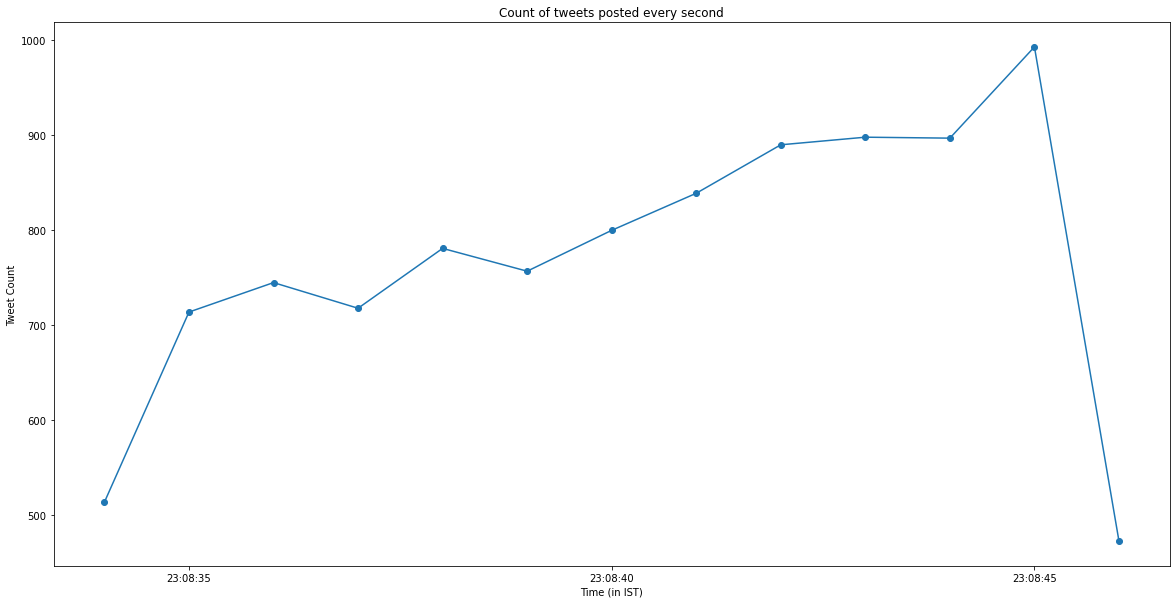

In [8]:
# Tweets vs Time plot

tweet_time = {}
for tweet in tweets:
    time_val = tweet.created_at
#     To zoom out, i.e. to watch count of tweets per minute, uncomment the next line
#     time_val = time_val.replace(second=0)
    if time_val not in tweet_time.keys():
        tweet_time[time_val]=0
    tweet_time[time_val]+=1

plt.figure(figsize=(20,10))
# plt.ylim(0, max(tweet_time.values())+5)
plt.gca().xaxis_date('Asia/Kolkata')
plt.plot(list(tweet_time.keys()),tweet_time.values(),  linestyle='-', marker='o')
plt.xlabel('Time (in IST)')
plt.ylabel('Tweet Count')
plt.title('Count of tweets posted every second')
plt.show()

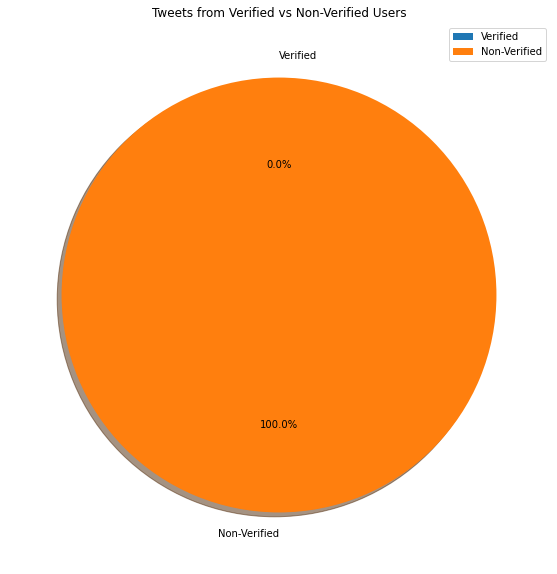

0.00% of users who posted this hashtag are verified


In [9]:
# For users info

user_verification={"Verified": 0, "Non-Verified": 0}
users={}

for tweet in tweets:
    author=tweet.author
    if author._json['screen_name'] not in users.keys():   
        if author.verified == True:
            user_verification["Verified"]+=1
        else:
            user_verification["Non-Verified"]+=1
    users[author._json['screen_name']] = {'statuses_count':author._json['statuses_count'], 'followers_count':author._json['followers_count'], 'friends_count':author._json['friends_count'], 'created_at':author.created_at}

plt.figure(figsize =(10, 10)) 
plt.pie(list(user_verification.values()), labels = list(user_verification.keys()), autopct='%1.1f%%',shadow=True, startangle=90)
plt.legend(loc="upper right")
plt.title("Tweets from Verified vs Non-Verified Users")
plt.show()


print("{:.2f}% of users who posted this hashtag are verified".format(100*(user_verification["Verified"]/(user_verification["Verified"]+user_verification["Non-Verified"]))))


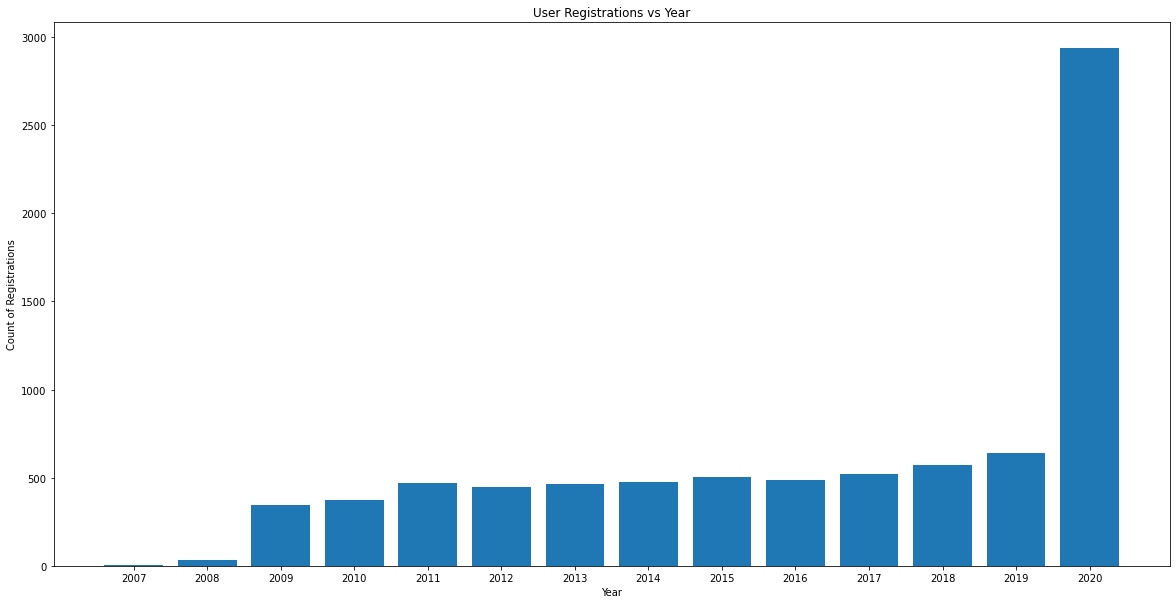

A total of 2938 users registered during 2020.


In [10]:
# User registrations per year

years_cnt = {2016:0}

for user in users:
    year = users[user]['created_at'].year
    if year not in years_cnt.keys():
        years_cnt[year] = 0
    years_cnt[year] += 1

for year in range(min(years_cnt.keys()), 2020+1):
    if year not in years_cnt.keys():
        years_cnt[year] = 0

years_cnt = dict(sorted(years_cnt.items(), key=lambda item: item[0]))
labels = [str(i) for i in years_cnt.keys()]

plt.figure(figsize=(20,10))
plt.bar(labels, years_cnt.values())
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Year')
plt.ylabel('Count of Registrations')
plt.title('User Registrations vs Year')
plt.show()

max_year = max(years_cnt.keys(), key=(lambda key: years_cnt[key]))
print("A total of {} users registered during {}.".format(years_cnt[max_year], max_year))

In [11]:
def get_user_info(id):
    user = api.get_user(screen_name=id)
    user_txt = "{} (@{})".format(user._json['name'], user._json['screen_name'])
    return user_txt

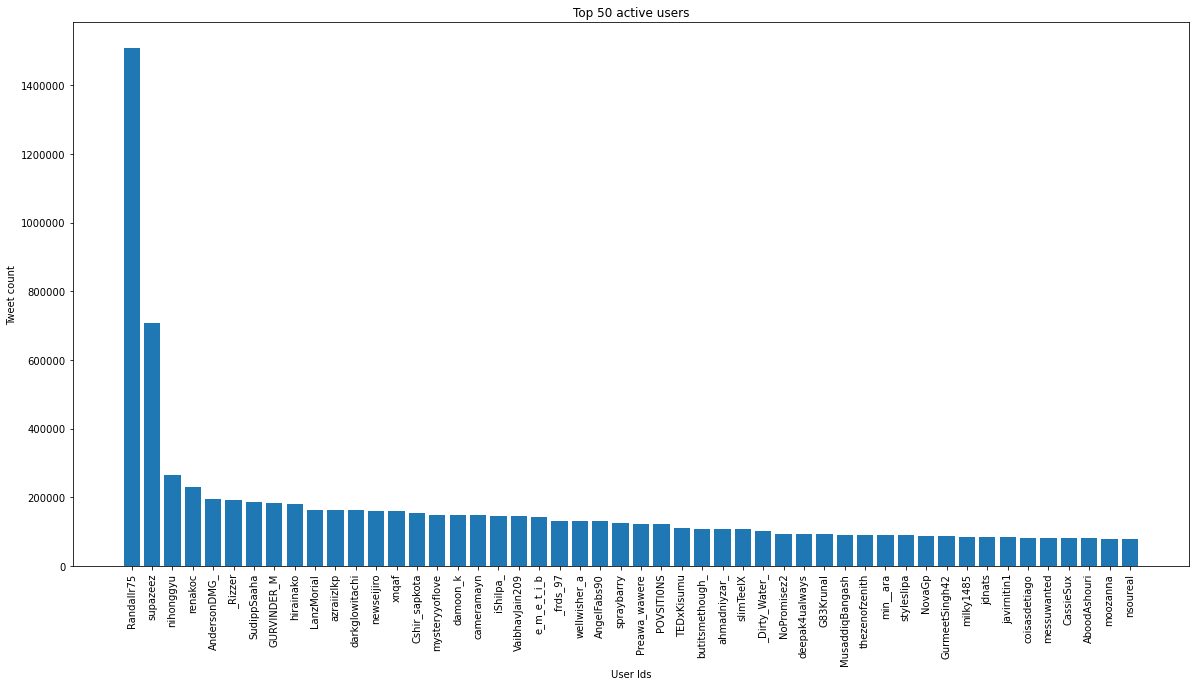

Randy•R (@Randallr75), adóbò láwìn (@supazeez), and LILY RAE IPHONE PLS ☾ (@nihonggyu) are the most active users among all the users available.


In [12]:
# Most active users with maximum number of tweets throughout his/her life
status = dict(sorted(users.items(), key=lambda item: item[1]['statuses_count'], reverse=True))
status_cnt = [x['statuses_count'] for x in status.values()]
status = list(status.keys())

fig = plt.figure(figsize =(20, 10))
plt.bar(status[:50], status_cnt[:50])
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.title('Top 50 active users')
plt.xlabel('User Ids')
plt.ylabel('Tweet count')
plt.show()


print("{}, {}, and {} are the most active users among all the users available.".format(get_user_info(status[0]), get_user_info(status[1]), get_user_info(status[2])))

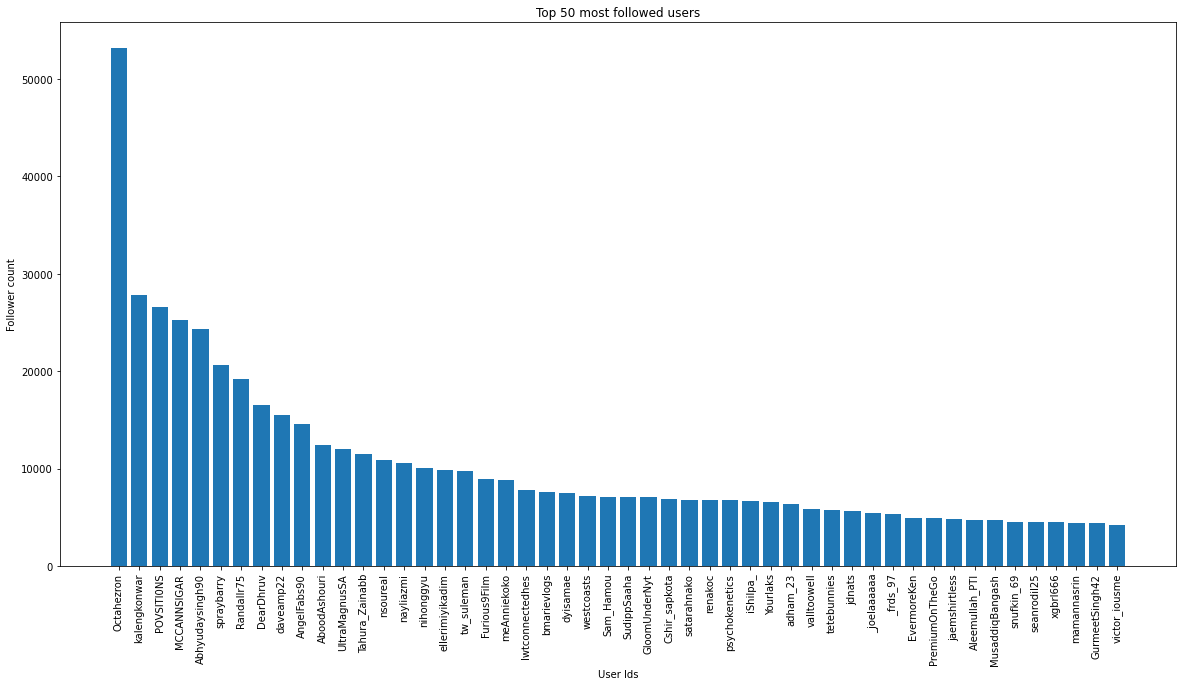

: (@Octahezron), Kaleng Konwar (@kalengkonwar), and gigi (@POVSITI0NS) are the top 3 most followed users among all the users available.


In [13]:
# Most followed users

labels = dict(sorted(users.items(), key=lambda item: item[1]['followers_count'], reverse=True))
follower_cnt = [x['followers_count'] for x in labels.values()]
labels = list(labels.keys())

fig = plt.figure(figsize =(20, 10))
plt.bar(labels[:50], follower_cnt[:50])
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.title('Top 50 most followed users')
plt.xlabel('User Ids')
plt.ylabel('Follower count')
plt.show()


print("{}, {}, and {} are the top 3 most followed users among all the users available.".format(get_user_info(labels[0]), get_user_info(labels[1]), get_user_info(labels[2])))

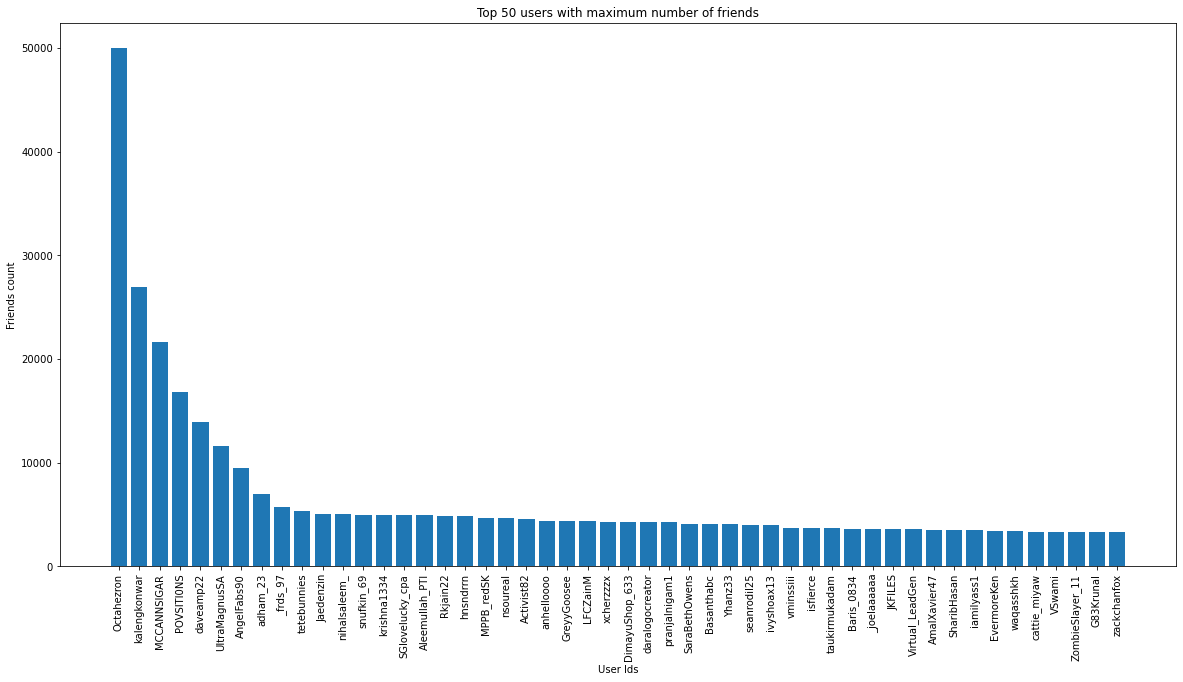

: (@Octahezron), Kaleng Konwar (@kalengkonwar), and Kristina (@MCCANNSIGAR) are the top 3 users with maximum number of friends among all the users available.


In [14]:
# Users having maximum number of friends

labels = dict(sorted(users.items(), key=lambda item: item[1]['friends_count'], reverse=True))
follower_cnt = [x['friends_count'] for x in labels.values()]
labels = list(labels.keys())

fig = plt.figure(figsize =(20, 10))
plt.bar(labels[:50], follower_cnt[:50])
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.title('Top 50 users with maximum number of friends')
plt.xlabel('User Ids')
plt.ylabel('Friends count')
plt.show()


print("{}, {}, and {} are the top 3 users with maximum number of friends among all the users available.".format(get_user_info(labels[0]), get_user_info(labels[1]), get_user_info(labels[2])))

In [15]:
# to fetch languages

# NOTE: obtained the following json from stackoverflow
languages = {
    "ab": {
        "name": "Abkhaz",
            "nativeName": "аҧсуа"
    },
        "aa": {
        "name": "Afar",
            "nativeName": "Afaraf"
    },
        "af": {
        "name": "Afrikaans",
            "nativeName": "Afrikaans"
    },
        "ak": {
        "name": "Akan",
            "nativeName": "Akan"
    },
        "sq": {
        "name": "Albanian",
            "nativeName": "Shqip"
    },
        "am": {
        "name": "Amharic",
            "nativeName": "አማርኛ"
    },
        "ar": {
        "name": "Arabic",
            "nativeName": "العربية"
    },
        "an": {
        "name": "Aragonese",
            "nativeName": "Aragonés"
    },
        "hy": {
        "name": "Armenian",
            "nativeName": "Հայերեն"
    },
        "as": {
        "name": "Assamese",
            "nativeName": "অসমীয়া"
    },
        "av": {
        "name": "Avaric",
            "nativeName": "авар мацӀ, магӀарул мацӀ"
    },
        "ae": {
        "name": "Avestan",
            "nativeName": "avesta"
    },
        "ay": {
        "name": "Aymara",
            "nativeName": "aymar aru"
    },
        "az": {
        "name": "Azerbaijani",
            "nativeName": "azərbaycan dili"
    },
        "bm": {
        "name": "Bambara",
            "nativeName": "bamanankan"
    },
        "ba": {
        "name": "Bashkir",
            "nativeName": "башҡорт теле"
    },
        "eu": {
        "name": "Basque",
            "nativeName": "euskara, euskera"
    },
        "be": {
        "name": "Belarusian",
            "nativeName": "Беларуская"
    },
        "bn": {
        "name": "Bengali",
            "nativeName": "বাংলা"
    },
        "bh": {
        "name": "Bihari",
            "nativeName": "भोजपुरी"
    },
        "bi": {
        "name": "Bislama",
            "nativeName": "Bislama"
    },
        "bs": {
        "name": "Bosnian",
            "nativeName": "bosanski jezik"
    },
        "br": {
        "name": "Breton",
            "nativeName": "brezhoneg"
    },
        "bg": {
        "name": "Bulgarian",
            "nativeName": "български език"
    },
        "my": {
        "name": "Burmese",
            "nativeName": "ဗမာစာ"
    },
        "ca": {
        "name": "Catalan; Valencian",
            "nativeName": "Català"
    },
        "ch": {
        "name": "Chamorro",
            "nativeName": "Chamoru"
    },
        "ce": {
        "name": "Chechen",
            "nativeName": "нохчийн мотт"
    },
        "ny": {
        "name": "Chichewa; Chewa; Nyanja",
            "nativeName": "chiCheŵa, chinyanja"
    },
        "zh": {
        "name": "Chinese",
            "nativeName": "中文 (Zhōngwén), 汉语, 漢語"
    },
        "cv": {
        "name": "Chuvash",
            "nativeName": "чӑваш чӗлхи"
    },
        "kw": {
        "name": "Cornish",
            "nativeName": "Kernewek"
    },
        "co": {
        "name": "Corsican",
            "nativeName": "corsu, lingua corsa"
    },
        "cr": {
        "name": "Cree",
            "nativeName": "ᓀᐦᐃᔭᐍᐏᐣ"
    },
        "hr": {
        "name": "Croatian",
            "nativeName": "hrvatski"
    },
        "cs": {
        "name": "Czech",
            "nativeName": "česky, čeština"
    },
        "da": {
        "name": "Danish",
            "nativeName": "dansk"
    },
        "dv": {
        "name": "Divehi; Dhivehi; Maldivian;",
            "nativeName": "ދިވެހި"
    },
        "nl": {
        "name": "Dutch",
            "nativeName": "Nederlands, Vlaams"
    },
        "en": {
        "name": "English",
            "nativeName": "English"
    },
        "eo": {
        "name": "Esperanto",
            "nativeName": "Esperanto"
    },
        "et": {
        "name": "Estonian",
            "nativeName": "eesti, eesti keel"
    },
        "ee": {
        "name": "Ewe",
            "nativeName": "Eʋegbe"
    },
        "fo": {
        "name": "Faroese",
            "nativeName": "føroyskt"
    },
        "fj": {
        "name": "Fijian",
            "nativeName": "vosa Vakaviti"
    },
        "fi": {
        "name": "Finnish",
            "nativeName": "suomi, suomen kieli"
    },
        "fr": {
        "name": "French",
            "nativeName": "français, langue française"
    },
        "ff": {
        "name": "Fula; Fulah; Pulaar; Pular",
            "nativeName": "Fulfulde, Pulaar, Pular"
    },
        "gl": {
        "name": "Galician",
            "nativeName": "Galego"
    },
        "ka": {
        "name": "Georgian",
            "nativeName": "ქართული"
    },
        "de": {
        "name": "German",
            "nativeName": "Deutsch"
    },
        "el": {
        "name": "Greek, Modern",
            "nativeName": "Ελληνικά"
    },
        "gn": {
        "name": "Guaraní",
            "nativeName": "Avañeẽ"
    },
        "gu": {
        "name": "Gujarati",
            "nativeName": "ગુજરાતી"
    },
        "ht": {
        "name": "Haitian; Haitian Creole",
            "nativeName": "Kreyòl ayisyen"
    },
        "ha": {
        "name": "Hausa",
            "nativeName": "Hausa, هَوُسَ"
    },
        "he": {
        "name": "Hebrew (modern)",
            "nativeName": "עברית"
    },
        "hz": {
        "name": "Herero",
            "nativeName": "Otjiherero"
    },
        "hi": {
        "name": "Hindi",
            "nativeName": "हिन्दी, हिंदी"
    },
        "ho": {
        "name": "Hiri Motu",
            "nativeName": "Hiri Motu"
    },
        "hu": {
        "name": "Hungarian",
            "nativeName": "Magyar"
    },
        "ia": {
        "name": "Interlingua",
            "nativeName": "Interlingua"
    },
        "id": {
        "name": "Indonesian",
            "nativeName": "Bahasa Indonesia"
    },
        "ie": {
        "name": "Interlingue",
            "nativeName": "Originally called Occidental; then Interlingue after WWII"
    },
        "ga": {
        "name": "Irish",
            "nativeName": "Gaeilge"
    },
        "ig": {
        "name": "Igbo",
            "nativeName": "Asụsụ Igbo"
    },
        "ik": {
        "name": "Inupiaq",
            "nativeName": "Iñupiaq, Iñupiatun"
    },
        "io": {
        "name": "Ido",
            "nativeName": "Ido"
    },
        "is": {
        "name": "Icelandic",
            "nativeName": "Íslenska"
    },
        "it": {
        "name": "Italian",
            "nativeName": "Italiano"
    },
        "iu": {
        "name": "Inuktitut",
            "nativeName": "ᐃᓄᒃᑎᑐᑦ"
    },
        "ja": {
        "name": "Japanese",
            "nativeName": "日本語 (にほんご／にっぽんご)"
    },
        "jv": {
        "name": "Javanese",
            "nativeName": "basa Jawa"
    },
        "kl": {
        "name": "Kalaallisut, Greenlandic",
            "nativeName": "kalaallisut, kalaallit oqaasii"
    },
        "kn": {
        "name": "Kannada",
            "nativeName": "ಕನ್ನಡ"
    },
        "kr": {
        "name": "Kanuri",
            "nativeName": "Kanuri"
    },
        "ks": {
        "name": "Kashmiri",
            "nativeName": "कश्मीरी, كشميري‎"
    },
        "kk": {
        "name": "Kazakh",
            "nativeName": "Қазақ тілі"
    },
        "km": {
        "name": "Khmer",
            "nativeName": "ភាសាខ្មែរ"
    },
        "ki": {
        "name": "Kikuyu, Gikuyu",
            "nativeName": "Gĩkũyũ"
    },
        "rw": {
        "name": "Kinyarwanda",
            "nativeName": "Ikinyarwanda"
    },
        "ky": {
        "name": "Kirghiz, Kyrgyz",
            "nativeName": "кыргыз тили"
    },
        "kv": {
        "name": "Komi",
            "nativeName": "коми кыв"
    },
        "kg": {
        "name": "Kongo",
            "nativeName": "KiKongo"
    },
        "ko": {
        "name": "Korean",
            "nativeName": "한국어 (韓國語), 조선말 (朝鮮語)"
    },
        "ku": {
        "name": "Kurdish",
            "nativeName": "Kurdî, كوردی‎"
    },
        "kj": {
        "name": "Kwanyama, Kuanyama",
            "nativeName": "Kuanyama"
    },
        "la": {
        "name": "Latin",
            "nativeName": "latine, lingua latina"
    },
        "lb": {
        "name": "Luxembourgish, Letzeburgesch",
            "nativeName": "Lëtzebuergesch"
    },
        "lg": {
        "name": "Luganda",
            "nativeName": "Luganda"
    },
        "li": {
        "name": "Limburgish, Limburgan, Limburger",
            "nativeName": "Limburgs"
    },
        "ln": {
        "name": "Lingala",
            "nativeName": "Lingála"
    },
        "lo": {
        "name": "Lao",
            "nativeName": "ພາສາລາວ"
    },
        "lt": {
        "name": "Lithuanian",
            "nativeName": "lietuvių kalba"
    },
        "lu": {
        "name": "Luba-Katanga",
            "nativeName": ""
    },
        "lv": {
        "name": "Latvian",
            "nativeName": "latviešu valoda"
    },
        "gv": {
        "name": "Manx",
            "nativeName": "Gaelg, Gailck"
    },
        "mk": {
        "name": "Macedonian",
            "nativeName": "македонски јазик"
    },
        "mg": {
        "name": "Malagasy",
            "nativeName": "Malagasy fiteny"
    },
        "ms": {
        "name": "Malay",
            "nativeName": "bahasa Melayu, بهاس ملايو‎"
    },
        "ml": {
        "name": "Malayalam",
            "nativeName": "മലയാളം"
    },
        "mt": {
        "name": "Maltese",
            "nativeName": "Malti"
    },
        "mi": {
        "name": "Māori",
            "nativeName": "te reo Māori"
    },
        "mr": {
        "name": "Marathi (Marāṭhī)",
            "nativeName": "मराठी"
    },
        "mh": {
        "name": "Marshallese",
            "nativeName": "Kajin M̧ajeļ"
    },
        "mn": {
        "name": "Mongolian",
            "nativeName": "монгол"
    },
        "na": {
        "name": "Nauru",
            "nativeName": "Ekakairũ Naoero"
    },
        "nv": {
        "name": "Navajo, Navaho",
            "nativeName": "Diné bizaad, Dinékʼehǰí"
    },
        "nb": {
        "name": "Norwegian Bokmål",
            "nativeName": "Norsk bokmål"
    },
        "nd": {
        "name": "North Ndebele",
            "nativeName": "isiNdebele"
    },
        "ne": {
        "name": "Nepali",
            "nativeName": "नेपाली"
    },
        "ng": {
        "name": "Ndonga",
            "nativeName": "Owambo"
    },
        "nn": {
        "name": "Norwegian Nynorsk",
            "nativeName": "Norsk nynorsk"
    },
        "no": {
        "name": "Norwegian",
            "nativeName": "Norsk"
    },
        "ii": {
        "name": "Nuosu",
            "nativeName": "ꆈꌠ꒿ Nuosuhxop"
    },
        "nr": {
        "name": "South Ndebele",
            "nativeName": "isiNdebele"
    },
        "oc": {
        "name": "Occitan",
            "nativeName": "Occitan"
    },
        "oj": {
        "name": "Ojibwe, Ojibwa",
            "nativeName": "ᐊᓂᔑᓈᐯᒧᐎᓐ"
    },
        "cu": {
        "name": "Old Church Slavonic, Church Slavic, Church Slavonic, Old Bulgarian, Old Slavonic",
            "nativeName": "ѩзыкъ словѣньскъ"
    },
        "om": {
        "name": "Oromo",
            "nativeName": "Afaan Oromoo"
    },
        "or": {
        "name": "Oriya",
            "nativeName": "ଓଡ଼ିଆ"
    },
        "os": {
        "name": "Ossetian, Ossetic",
            "nativeName": "ирон æвзаг"
    },
        "pa": {
        "name": "Panjabi, Punjabi",
            "nativeName": "ਪੰਜਾਬੀ, پنجابی‎"
    },
        "pi": {
        "name": "Pāli",
            "nativeName": "पाऴि"
    },
        "fa": {
        "name": "Persian",
            "nativeName": "فارسی"
    },
        "pl": {
        "name": "Polish",
            "nativeName": "polski"
    },
        "ps": {
        "name": "Pashto, Pushto",
            "nativeName": "پښتو"
    },
        "pt": {
        "name": "Portuguese",
            "nativeName": "Português"
    },
        "qu": {
        "name": "Quechua",
            "nativeName": "Runa Simi, Kichwa"
    },
        "rm": {
        "name": "Romansh",
            "nativeName": "rumantsch grischun"
    },
        "rn": {
        "name": "Kirundi",
            "nativeName": "kiRundi"
    },
        "ro": {
        "name": "Romanian, Moldavian, Moldovan",
            "nativeName": "română"
    },
        "ru": {
        "name": "Russian",
            "nativeName": "русский язык"
    },
        "sa": {
        "name": "Sanskrit (Saṁskṛta)",
            "nativeName": "संस्कृतम्"
    },
        "sc": {
        "name": "Sardinian",
            "nativeName": "sardu"
    },
        "sd": {
        "name": "Sindhi",
            "nativeName": "सिन्धी, سنڌي، سندھی‎"
    },
        "se": {
        "name": "Northern Sami",
            "nativeName": "Davvisámegiella"
    },
        "sm": {
        "name": "Samoan",
            "nativeName": "gagana faa Samoa"
    },
        "sg": {
        "name": "Sango",
            "nativeName": "yângâ tî sängö"
    },
        "sr": {
        "name": "Serbian",
            "nativeName": "српски језик"
    },
        "gd": {
        "name": "Scottish Gaelic; Gaelic",
            "nativeName": "Gàidhlig"
    },
        "sn": {
        "name": "Shona",
            "nativeName": "chiShona"
    },
        "si": {
        "name": "Sinhala, Sinhalese",
            "nativeName": "සිංහල"
    },
        "sk": {
        "name": "Slovak",
            "nativeName": "slovenčina"
    },
        "sl": {
        "name": "Slovene",
            "nativeName": "slovenščina"
    },
        "so": {
        "name": "Somali",
            "nativeName": "Soomaaliga, af Soomaali"
    },
        "st": {
        "name": "Southern Sotho",
            "nativeName": "Sesotho"
    },
        "es": {
        "name": "Spanish; Castilian",
            "nativeName": "español, castellano"
    },
        "su": {
        "name": "Sundanese",
            "nativeName": "Basa Sunda"
    },
        "sw": {
        "name": "Swahili",
            "nativeName": "Kiswahili"
    },
        "ss": {
        "name": "Swati",
            "nativeName": "SiSwati"
    },
        "sv": {
        "name": "Swedish",
            "nativeName": "svenska"
    },
        "ta": {
        "name": "Tamil",
            "nativeName": "தமிழ்"
    },
        "te": {
        "name": "Telugu",
            "nativeName": "తెలుగు"
    },
        "tg": {
        "name": "Tajik",
            "nativeName": "тоҷикӣ, toğikī, تاجیکی‎"
    },
        "th": {
        "name": "Thai",
            "nativeName": "ไทย"
    },
        "ti": {
        "name": "Tigrinya",
            "nativeName": "ትግርኛ"
    },
        "bo": {
        "name": "Tibetan Standard, Tibetan, Central",
            "nativeName": "བོད་ཡིག"
    },
        "tk": {
        "name": "Turkmen",
            "nativeName": "Türkmen, Түркмен"
    },
        "tl": {
        "name": "Tagalog",
            "nativeName": "Wikang Tagalog, ᜏᜒᜃᜅ᜔ ᜆᜄᜎᜓᜄ᜔"
    },
        "tn": {
        "name": "Tswana",
            "nativeName": "Setswana"
    },
        "to": {
        "name": "Tonga (Tonga Islands)",
            "nativeName": "faka Tonga"
    },
        "tr": {
        "name": "Turkish",
            "nativeName": "Türkçe"
    },
        "ts": {
        "name": "Tsonga",
            "nativeName": "Xitsonga"
    },
        "tt": {
        "name": "Tatar",
            "nativeName": "татарча, tatarça, تاتارچا‎"
    },
        "tw": {
        "name": "Twi",
            "nativeName": "Twi"
    },
        "ty": {
        "name": "Tahitian",
            "nativeName": "Reo Tahiti"
    },
        "ug": {
        "name": "Uighur, Uyghur",
            "nativeName": "Uyƣurqə, ئۇيغۇرچە‎"
    },
        "uk": {
        "name": "Ukrainian",
            "nativeName": "українська"
    },
        "ur": {
        "name": "Urdu",
            "nativeName": "اردو"
    },
        "uz": {
        "name": "Uzbek",
            "nativeName": "zbek, Ўзбек, أۇزبېك‎"
    },
        "ve": {
        "name": "Venda",
            "nativeName": "Tshivenḓa"
    },
        "vi": {
        "name": "Vietnamese",
            "nativeName": "Tiếng Việt"
    },
        "vo": {
        "name": "Volapük",
            "nativeName": "Volapük"
    },
        "wa": {
        "name": "Walloon",
            "nativeName": "Walon"
    },
        "cy": {
        "name": "Welsh",
            "nativeName": "Cymraeg"
    },
        "wo": {
        "name": "Wolof",
            "nativeName": "Wollof"
    },
        "fy": {
        "name": "Western Frisian",
            "nativeName": "Frysk"
    },
        "xh": {
        "name": "Xhosa",
            "nativeName": "isiXhosa"
    },
        "yi": {
        "name": "Yiddish",
            "nativeName": "ייִדיש"
    },
        "yo": {
        "name": "Yoruba",
            "nativeName": "Yorùbá"
    },
        "za": {
        "name": "Zhuang, Chuang",
            "nativeName": "Saɯ cueŋƅ, Saw cuengh"
    },
}

def get_lang_text(code):
    if code in languages.keys():
        return languages[code]["name"]
    return "Unknown"


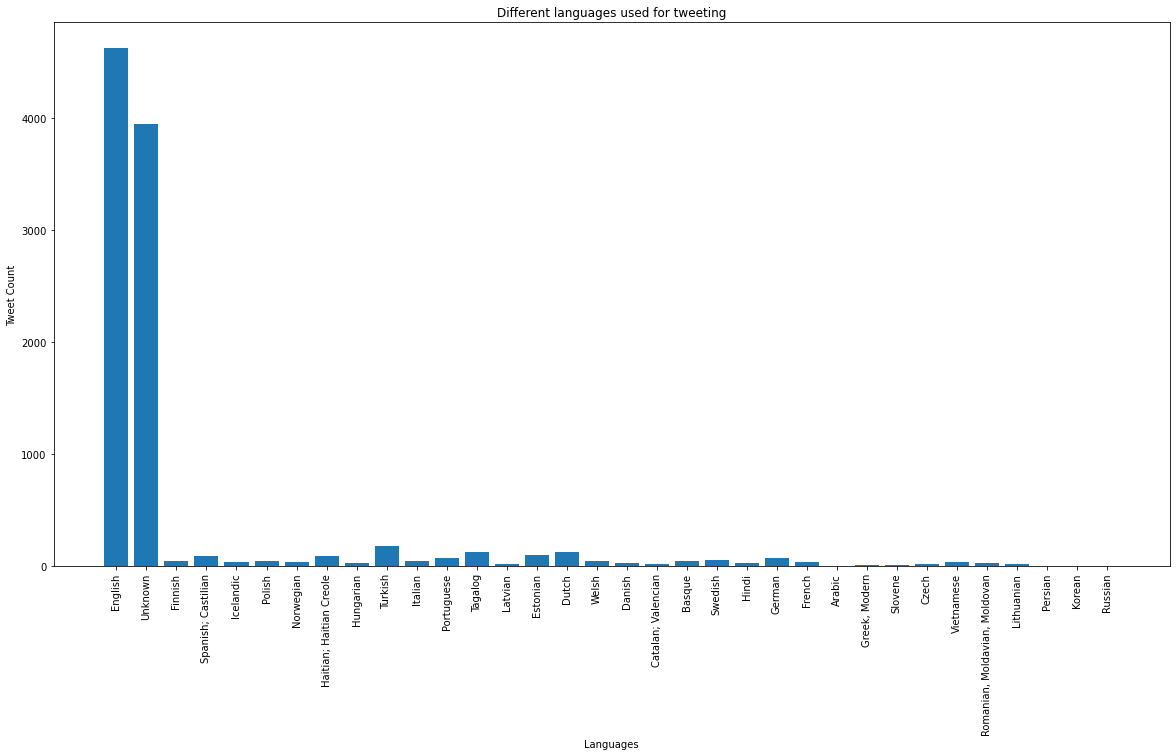

English is the most used language among the tweets.


In [16]:
# for language aspect

lang_cnt={}

for tweet in tweets:
    lang=get_lang_text(tweet.lang)
    if lang not in lang_cnt:
        lang_cnt[lang] = 0
    lang_cnt[lang]+=1
    
language_code = []
language_freq = []

most_used_lang = []
max_lang_freq = 0

for code in lang_cnt.keys():
    language_code.append(code)
    language_freq.append(lang_cnt[code])
    
    if lang_cnt[code] == max_lang_freq:
        most_used_lang.append(code)
    elif lang_cnt[code] > max_lang_freq:
        most_used_lang = []
        most_used_lang.append(code)
        max_lang_freq = lang_cnt[code]

plt.figure(figsize=(20, 10))
plt.bar(language_code, language_freq)
plt.xticks(rotation=90)
plt.xlabel('Languages')
plt.ylabel('Tweet Count')
plt.title('Different languages used for tweeting')
plt.show()



print('{} {} among the tweets.'.format(', '.join(str(e) for e in most_used_lang), 'is the most used language' if len(most_used_lang)==1 else 'are the most used languages'))

In [17]:
# Developed by: Shlok Pandey (@b30wulffz)